# Rethinking Statistics course in pymc3 - Week 8

Lecture 15: Multilevel Models

- [Video](https://www.youtube.com/watch?v=AALYPv5xSos)
- [Slides](https://speakerdeck.com/rmcelreath/l15-statistical-rethinking-winter-2019)

Lecture 16: Multilevel Models 2

- [Video](https://www.youtube.com/watch?v=ZG3Oe35R5sY)
- [Slides](https://speakerdeck.com/rmcelreath/l16-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week08.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week08_solutions.pdf) for the exercises of the week.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
from scipy import stats
from scipy.special import expit as logistic
from sklearn import preprocessing

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import warnings
warnings.filterwarnings('ignore')

## Exercise 1

> Revisit the Reed frog survival data, `reedfrogs`, and add the predation and size treatment variables to the varying intercepts model. Consider models with either predictor alone, both predictors, as well as a model including their interaction. What do you infer about the causal influence of these predictor variables? Also focus on the inferred variation across tanks (the σ across tanks). Explain why it changes as it does across models with different predictors included.

Let's get the data.

In [2]:
d = pd.read_csv('../../data/reedfrogs.csv', header=0, sep=';')
d['S'] = d.surv
d['n'] = d.density
d['tank'] = d.index
d['pred'] = pd.factorize(d['pred'])[0]
#d['size'] = pd.factorize(d['size'])[0]
d['size'] = np.where(d['size']=='small',0,1)
d.head()

,density,pred,size,surv,propsurv,S,n,tank
0,10,0,1,9,0.9,9,10,0
1,10,0,1,10,1.0,10,10,1
2,10,0,1,7,0.7,7,10,2
3,10,0,1,10,1.0,10,10,3
4,10,0,0,9,0.9,9,10,4


In [3]:
n = theano.shared(d['n'].values)
tank = theano.shared(d['tank'].values)
pred = theano.shared(d['pred'].values)
size = theano.shared(d['size'].values)
S = theano.shared(d['S'].values)

Now to define a series of models. The first is just the varying intercepts model from the text.

Model 1:

In [4]:
with pm.Model() as model_11:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', lam=1)
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=len(d['tank'].unique()))
    
    # Logistic regression
    p = pm.math.invlogit(a[tank])
    surv_hat = pm.Binomial('surv_hat', p=p, n=n, observed=S)

    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_11 = pm.sample(tune=1000)
    posterior_pred_11 = pm.sample_posterior_predictive(posterior_11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
100%|██████████| 2000/2000 [00:39<00:00, 50.12it/s]


Model 2 (pred):

In [5]:
with pm.Model() as model_12:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', lam=1)
    bp = pm.Normal('bp', mu=-0.5, sd=1)
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=len(d['tank'].unique()))
    
    # Logistic regression
    p = pm.math.invlogit(a[tank]+bp*pred)
    surv_hat = pm.Binomial('surv_hat', p=p, n=n, observed=S)

    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_12 = pm.sample(tune=1000)
    posterior_pred_12 = pm.sample_posterior_predictive(posterior_12)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bp, sigma, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:12<00:00, 480.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 2000/2000 [00:41<00:00, 48.16it/s]


Model 3 (size):

In [6]:
with pm.Model() as model_13:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', lam=1)
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=len(d['tank'].unique()))
    s = pm.Normal('s', mu=0, sd=0.5, shape=len(d['size'].unique()))
    
    # Logistic regression
    p = pm.math.invlogit(a[tank] + s[size])
    surv_hat = pm.Binomial('surv_hat', p=p, n=n, observed=S)

    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_13 = pm.sample(tune=1000)
    posterior_pred_13 = pm.sample_posterior_predictive(posterior_13)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, a, sigma, a_bar]
100%|██████████| 2000/2000 [00:39<00:00, 59.80it/s]


Model 4 (pred + size):

In [7]:
with pm.Model() as model_14:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', lam=1)
    bp = pm.Normal('bp', mu=-0.5, sd=1)
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=len(d['tank'].unique()))
    s = pm.Normal('s', mu=0, sd=0.5, shape=len(d['size'].unique()))
    
    # Logistic regression
    p = pm.math.invlogit(a[tank]+bp*pred+s[size])
    surv_hat = pm.Binomial('surv_hat', p=p, n=n, observed=S)

    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_14 = pm.sample(tune=1000)
    posterior_pred_14 = pm.sample_posterior_predictive(posterior_14)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, a, bp, sigma, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:13<00:00, 457.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 2000/2000 [00:40<00:00, 49.33it/s]


Model 5 (pred + size + interaction):

In [16]:
with pm.Model() as model_15:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', lam=1)
    bp = pm.Normal('bp', mu=-0.5, sd=1, shape=len(d['size'].unique()))
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=len(d['tank'].unique()))
    s = pm.Normal('s', mu=0, sd=0.5, shape=len(d['size'].unique()))
    
    # Logistic regression
    p = pm.math.invlogit(a[tank] + bp[size]*pred + s[size])
    surv_hat = pm.Binomial('surv_hat', p=p, n=n, observed=S)

    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_15 = pm.sample(tune=1000)
    #posterior_pred_15 = pm.sample_posterior_predictive(posterior_15)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, a, bp, sigma, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:12<00:00, 464.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


I coded the interaction model (`model_15`) using a non-centered parameterization. The interaction itself is done by creating a `bp` parameter for each size value. In this way, the effect of `pred` depends upon `size`. First let's consider the WAIC scores:

In [17]:
model_11.name = 'model_11'
model_12.name = 'model_12'
model_13.name = 'model_13'
model_14.name = 'model_14'
model_15.name = 'model_15'

In [63]:
pm.compare({model_11: posterior_11,
            model_12: posterior_12,
            model_13: posterior_13,
            model_14: posterior_14,
            model_15: posterior_15})

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model_12,199.03,19.29,0,0.21,9.06,0,1
model_15,199.16,18.82,0.13,0.39,9.06,3.11,1
model_11,199.27,20.55,0.25,0.39,7.28,5.94,1
model_13,200.01,20.86,0.98,0,7.11,5.63,1
model_14,200.46,19.23,1.44,0,8.78,1.85,1


These models are really very similar in expected out-of-sample accuracy. The tank variation is huge. But take a look at the posterior distributions for predation and size. You'll see that predation does seem to matter, as you'd expect. Size matters a lot less. So while predation doesn't explain much of the total variation, there is plenty of evidence that it is a real effect. Remember: We don't select a model using WAIC
(or LOO). A predictor can make little difference in total accuracy but still be a real causal effect.

Let's look at all the sigma posterior distributions:

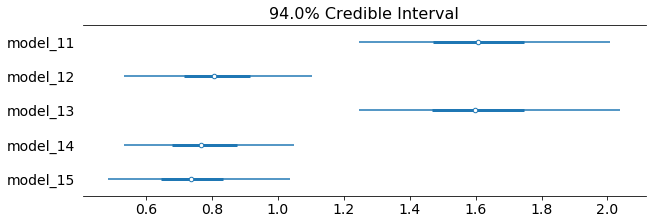

In [19]:
az.plot_forest({
    'model_11': posterior_11['sigma'],
    'model_12': posterior_12['sigma'],
    'model_13': posterior_13['sigma'],
    'model_14': posterior_14['sigma'],
    'model_15': posterior_15['sigma']
},figsize=(9, 3));

The two models that omit predation, `model_11` and `model_13`, have larger values of `sigma`. This is because predation explains some of the variation among tanks. So when you add it to the model, the variation in the tank intercepts gets smaller.

## Exercise 2

> In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 2000, a typical Bengali woman had only 2 or 3. You're going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in data `bangladesh` and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on two of them for this practice problem:

> 1. district: ID number of administrative district each woman resided in
2. use.contraception: An indicator (0/1) of whether the woman was using contraception

In [21]:
d = pd.read_csv('../../data/bangladesh.csv', header=0, sep=';')
d['did'] = pd.factorize(d['district'])[0]
d.head()

,woman,district,use.contraception,living.children,age.centered,urban,did
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


In [22]:
did = theano.shared(d['did'].values)
C = theano.shared(d['use.contraception'].values)

Now for the ordinary fixed effect model:

In [26]:
with pm.Model() as model_21:
    # Data is defined outside of the model
    
    # Priors
    a = pm.Normal('a', mu=0, sd=1.5, shape=len(d['did'].unique()))
    
    # Logistic regression
    p = pm.math.invlogit(a[did])
    conc_hat = pm.Bernoulli('conc_hat', p=p, observed=C)

    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_21 = pm.sample(tune=1000)
    posterior_pred_21 = pm.sample_posterior_predictive(posterior_21)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
100%|██████████| 2000/2000 [00:39<00:00, 50.77it/s]


In [27]:
with pm.Model() as model_22:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', lam=1)
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=len(d['district'].unique()))
    
    # Logistic regression
    p = pm.math.invlogit(a[did])
    conc_hat = pm.Bernoulli('conc_hat', p=p, observed=C)

    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_22 = pm.sample(tune=1000)
    posterior_pred_22 = pm.sample_posterior_predictive(posterior_22)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
100%|██████████| 2000/2000 [00:39<00:00, 51.12it/s]


Now let's extract the samples, compute posterior mean probabilities in each district, and plot it all:

In [28]:
aux = pd.concat([pd.DataFrame(logistic(posterior_21['a'].mean(axis=0))).assign(model='model_21'),
           pd.DataFrame(logistic(posterior_22['a'].mean(axis=0))).assign(model='model_22')]).rename(columns={0:'prob'}).reset_index()

In [52]:
logistic(posterior_22['a_bar'].mean()) # use it for the red line in the next plot

0.368885625151105

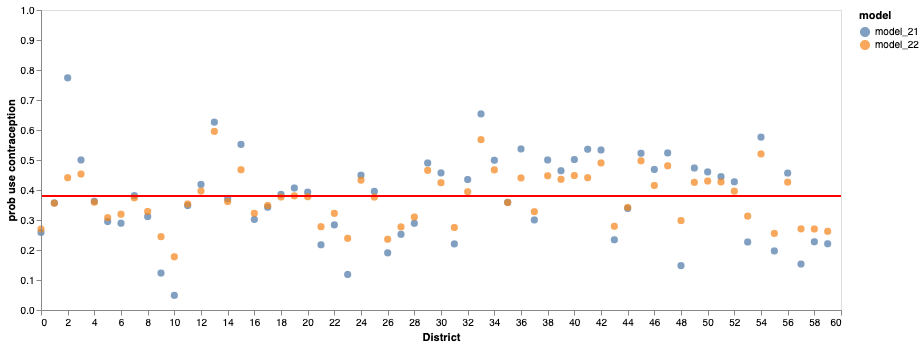

In [58]:
plot = alt.Chart(aux).mark_circle(size = 50).encode(
            alt.X('index', title='District'),
            alt.Y('prob', title='prob use contraception',scale=alt.Scale(domain=(0, 1))),
            color = 'model')

rule = alt.Chart(aux).mark_rule(color='red',)\
    .encode(
    y='a:Q',
    size=alt.value(1)
           )

(plot+rule).transform_calculate(a="0.38").properties(width=800).configure_axis(grid=False)

The blue points are the fixed estimations. The _orange ones_ points are the varying effects. As you'd expect, they are shrunk towards the mean (the _red_ line). Some are shrunk more than others. The third district from the left shrunk a lot. Let's look at the sample size in each district:

In [59]:
pd.DataFrame(d.district.value_counts().sort_index()).T

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,55,56,57,58,59,60,61
district,117,20,2,30,39,65,18,37,23,13,...,37,61,19,6,45,27,33,10,32,42


District 3 has only 2 women sampled. So it shrinks a lot. There are couple of other districts, like 49 and 54, that also have very few women sampled. But their fixed estimates aren't as extreme, so they don't shrink as much as district 3 does.

All of this is explained by partial pooling, of course.

## Exercise 3

Return to the Trolley data, (`Trolley`), from Chapter 12. Define and fit a varying intercepts model for these data. By this I mean to add an intercept parameter for the individual to the linear model. Cluster the varying intercepts on individual participants, as indicated by the unique values in the id variable. Include action, intention, and contact as before. Compare the varying intercepts model and a model that ignores individuals, using both WAIC/LOO and posterior predictions. What is the impact of individual variation in these data?

In [60]:
d = pd.read_csv('../../data/Trolley.csv', header=0, sep=';')

elvl = d['edu'].unique()
idx = [7 , 0 , 6 , 4 , 2 , 1, 3, 5]
cat = pd.Categorical(d.edu, categories=list(elvl[idx]), ordered=True)
d['edu_new'] = pd.factorize(cat, sort=True)[0].astype('Int64')

#d['edu_norm'] = preprocessing.normalize(np.array(d['edu_new']).reshape(-1, 1), axis = 0, norm='max')
d['age_std'] = preprocessing.scale(d['age'])
d['id'] = pd.factorize(d['id'])[0]
d['response'] = d['response']-1 # note this minus 1 to start the variable at zero, this way you don't have to put observed = response - 1 in the model
d.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,edu_new,age_std
0,cfaqu,3,2,0,14,0,Middle School,0,0,1,aqu,1,1,-1.650358
1,cfbur,2,31,0,14,0,Middle School,0,0,1,bur,1,1,-1.650358
2,cfrub,3,16,0,14,0,Middle School,0,0,1,rub,1,1,-1.650358
3,cibox,2,32,0,14,0,Middle School,0,1,1,box,1,1,-1.650358
4,cibur,2,4,0,14,0,Middle School,0,1,1,bur,1,1,-1.650358


In [61]:
action = theano.shared(d['action'].values)
contact = theano.shared(d['contact'].values)
intention = theano.shared(d['intention'].values)
id = theano.shared(d['id'].values)
response = theano.shared(d['response'].values)

First, let's load the data and re-run the old model from Chapter 12:

In [63]:
with pm.Model() as model_31:
    # Data is defined outside of the model
    
    # Priors
    cutpoints = pm.Normal('cutpoints',
                          mu=0,
                          sd=1.5,
                          transform=pm.distributions.transforms.ordered,
                          shape=len(d.response.unique())-1,
                          testval=np.arange(len(d.response.unique())-1) - 2.5)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    bC = pm.Normal('bC', mu=0, sd=0.5)
    bI = pm.Normal('bI', mu=0, sd=0.5)
    bIA = pm.Normal('bIA', mu=0, sd=0.5)
    bIC = pm.Normal('bIC', mu=0, sd=0.5)
    
    # Regression
    BI = bI + bIA*action + bIC*contact
    phi = bA*action + bC*contact + BI*intention
    response_hat = pm.OrderedLogistic('response_hat', phi, cutpoints, observed=response)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_31 = pm.sample()
    #posterior_pred_31 = pm.sample_posterior_predictive(posterior_31)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [02:08<00:00, 31.21draws/s]


Now to run the varying intercept model, we need to build a valid individual ID variable. The IDs in the data are long tags, so we can coerce them to integers in many ways. What is important is that the index values go from 1 (_zero in python_) to the number of individuals.

In [65]:
with pm.Model() as model_32:
    # Data is defined outside of the model
    
    # Priors
    cutpoints = pm.Normal('cutpoints',
                          mu=0,
                          sd=1.5,
                          transform=pm.distributions.transforms.ordered,
                          shape=len(d.response.unique())-1,
                          testval=np.arange(len(d.response.unique())-1) - 2.5)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    bC = pm.Normal('bC', mu=0, sd=0.5)
    bI = pm.Normal('bI', mu=0, sd=0.5)
    bIA = pm.Normal('bIA', mu=0, sd=0.5)
    bIC = pm.Normal('bIC', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    a = pm.Normal('a', mu=0, sd=sigma, shape=len(d['id'].unique()))
    
    # Regression
    BI = bI + bIA*action + bIC*contact
    phi = a[id]+ bA*action + bC*contact + BI*intention
    response_hat = pm.OrderedLogistic('response_hat', phi, cutpoints, observed=response)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_32 = pm.sample()
    #posterior_pred_32 = pm.sample_posterior_predictive(posterior_32)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, bIC, bIA, bI, bC, bA, cutpoints]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [08:58<00:00,  2.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


We can begin by comparing the posterior distributions. The original coefficients are:

In [64]:
az.summary(posterior_31, var_names=['bA', 'bC', 'bI', 'bIA', 'bIC'], credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,-0.47,0.05,0.0,0.0,-0.55,-0.38,1140.0,1140.0,1133.0,1418.0,1.0
bC,-0.34,0.07,0.0,0.0,-0.46,-0.24,1301.0,1301.0,1305.0,1129.0,1.0
bI,-0.29,0.06,0.0,0.0,-0.38,-0.20,1106.0,1100.0,1106.0,1528.0,1.0
bIA,-0.44,0.08,0.0,0.0,-0.56,-0.31,1168.0,1152.0,1166.0,1450.0,1.0
bIC,-1.23,0.10,0.0,0.0,-1.40,-1.09,1351.0,1331.0,1364.0,1392.0,1.0


And the new ones, having added the individual IDs, are:

In [66]:
az.summary(posterior_32, var_names=['bA', 'bC', 'bI', 'bIA', 'bIC', 'sigma'], credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,-0.65,0.06,0.0,0.0,-0.74,-0.56,1397.0,1397.0,1385.0,1832.0,1.00
bC,-0.45,0.07,0.0,0.0,-0.56,-0.33,1415.0,1415.0,1402.0,1350.0,1.00
bI,-0.39,0.06,0.0,0.0,-0.48,-0.29,1274.0,1267.0,1275.0,1375.0,1.00
bIA,-0.56,0.08,0.0,0.0,-0.68,-0.43,1439.0,1431.0,1437.0,1681.0,1.00
bIC,-1.67,0.10,0.0,0.0,-1.83,-1.51,1369.0,1352.0,1362.0,1239.0,1.00
sigma,1.92,0.08,0.0,0.0,1.80,2.05,1649.0,1636.0,1669.0,1385.0,1.01


Everything has gotten more negative. This is because there is a lot of individual variation in average rating, look at the distribution for sigma. That is on the $logit$ scale, so that's a lot of variation on the probability scale. That variation in average rating was hiding some of the effect of the treatments. We get more precision by conditioning on individual.

The WAIC comparison can also help show how much variation comes from individual differences in average rating:

In [67]:
model_31.name = 'model_31'
model_32.name = 'model_32'

In [68]:
pm.compare({model_31: posterior_31, model_32: posterior_32})

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model_32,31061,358.04,0,0.91,179.37,0,1
model_31,36928.9,10.81,5867.96,0.09,80.68,173.54,0


The WAIC difference is massive. This is consistent with individual variation in average rating being a major effect in this sample. This is all quite typical of likert-scale data, in my experience. Individuals anchor on different points and this adds noise. When we have repeat samples from the same individual, we can condition away some of that noise and get more precise estimates of the treatment effects.